### Lab 1

In [2]:
import scipy
import astroplan
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.time import Time 
import astropy.units as u  
import pandas as pd

from astroplan import Observer, FixedTarget

Set up the observing location

In [7]:
kittpeak = Observer(longitude = -111.5967 * u.deg,
               latitude = 31.9583 * u.deg,
               elevation = 2120 * u.m,
               timezone = 'US/Mountain',
               name = "KittPeak"
              )

In [88]:
window_start = Time("2020-05-14 12:00:00")
window_end = Time("2020-05-15 12:00:00") #These start and end times are assuming that I have the night of the 14th and day of the 15th to observe

In [90]:
print(window_start.to_datetime(kittpeak.timezone))
print(window_end.to_datetime(kittpeak.timezone))

2020-05-14 06:00:00-06:00
2020-05-15 06:00:00-06:00


Determine the start/end time and the length of the observign run for Kitt Peak Observatory

This uses UTC time, as well as Astronomical Twilight as the start and end time of the observing run

In [11]:
observe_start = kittpeak.twilight_evening_astronomical(window_start, which = 'next')
observe_end  = kittpeak.twilight_morning_astronomical(window_end, which = 'nearest')
obs_length = observe_end - observe_start
print(observe_start.to_datetime(kittpeak.timezone))
print(observe_end.to_datetime(kittpeak.timezone))
print("The observing window on May 14th at Kitt Peak is {}".format(obs_length.to_datetime()))

2020-06-14 22:13:50.665970-06:00
2020-06-15 04:39:59.833399-06:00
The observing window on May 14th at Kitt Peak is 6:26:09.167429


Reading in the data: 

The CSV containing the stars is ~9000 rows so I will only take the top 200 or so. 


In [12]:
target_values = pd.read_csv('./data/cumulative_2020.04.17_09.37.03.csv', comment = '#')
target_values_mask = target_values['rowid'] < 20
target_values = target_values[target_values_mask]
new_table = pd.DataFrame(data = target_values['kepoi_name'], columns =['kepoi_name'])
new_table['ra'] = target_values['ra']
new_table['dec'] = target_values['dec']


In [13]:
target_table = new_table.values
target = [FixedTarget(coord=SkyCoord(ra = ra*u.deg, dec = dec*u.deg), name = kepoi_name)
         for kepoi_name, ra, dec in target_table]

No for the constraints: 
First off is the moon. The moon phase can be googled for that date. The moon will be in the third quarter.

In [3]:
from astropy.coordinates import get_sun, get_body, get_moon
from astroplan import moon_illumination

In [127]:
moon = get_body('moon',observe_start)
print(moon_illumination(observe_start))
print(moon_illumination(observe_end))


0.4453470959215573
0.4170599671004638


This indicates that the moon will a little less half illuminated during my observations

In [4]:
from astroplan import MoonSeparationConstraint, AirmassConstraint
from astroplan import observability_table
from astroplan import time_grid_from_range
from astroplan.plots import plot_sky, plot_airmass

constraints = [MoonSeparationConstraint(70*u.deg)]

In [129]:
window_range = [window_start, window_end]
window_time_grid = time_grid_from_range(window_range)

In [130]:
observing_range = [observe_start, observe_end]
obsTable = observability_table(constraints, kittpeak, target, time_range = observing_range)
print(obsTable)

target name ever observable always observable fraction of time observable
----------- --------------- ----------------- ---------------------------
  K00752.01            True              True                         1.0
  K00752.02            True              True                         1.0
  K00753.01            True              True                         1.0
  K00754.01            True              True                         1.0
  K00755.01            True              True                         1.0
  K00756.01            True              True                         1.0
  K00756.02            True              True                         1.0
  K00756.03            True              True                         1.0
  K00114.01           False             False                         0.0
  K00757.01            True              True                         1.0
  K00001.01            True              True                         1.0
  K00002.01            True           

According to the above table, there are at least 10 objects that will be observable for the entire duration of my observing window.

The next constraint will be the airmass. 

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

from astroplan import time_grid_from_range

from astroplan.plots import plot_airmass

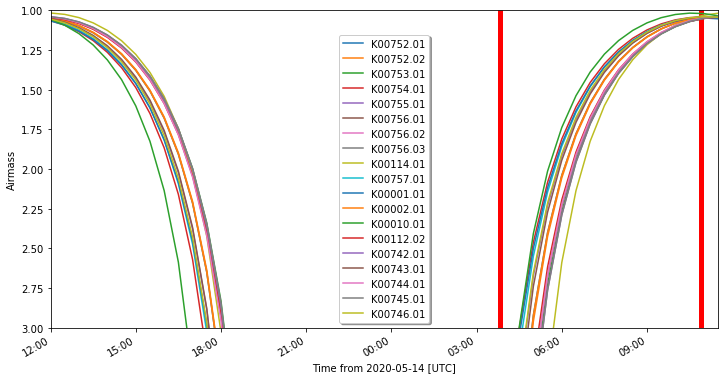

In [132]:

fig,ax = plt.subplots(1,1)
fig.set_size_inches(10,5)

fig.tight_layout()

for my_object in target:
    ax = plot_airmass(my_object, kittpeak, window_time_grid)

ax.vlines(observe_start.datetime, 1,3, color='r', linewidth=5)
ax.vlines(observe_end.datetime, 1,3, color='r', linewidth=5)

ax.legend(loc=0,shadow=True);

Looks like they will all be observable during my window. 
Now I'll add the airmass to my list of constraints

In [136]:
constraints.append(AirmassConstraint(2))
obsTable = observability_table(constraints, kittpeak, target, time_range = observing_range)
print(obsTable)

target name ever observable always observable fraction of time observable
----------- --------------- ----------------- ---------------------------
  K00752.01            True             False          0.6666666666666666
  K00752.02            True             False          0.6666666666666666
  K00753.01            True             False                         0.6
  K00754.01            True             False          0.7333333333333333
  K00755.01            True             False          0.6666666666666666
  K00756.01            True             False                         0.6
  K00756.02            True             False                         0.6
  K00756.03            True             False                         0.6
  K00114.01           False             False                         0.0
  K00757.01            True             False          0.7333333333333333
  K00001.01            True             False          0.7333333333333333
  K00002.01            True           

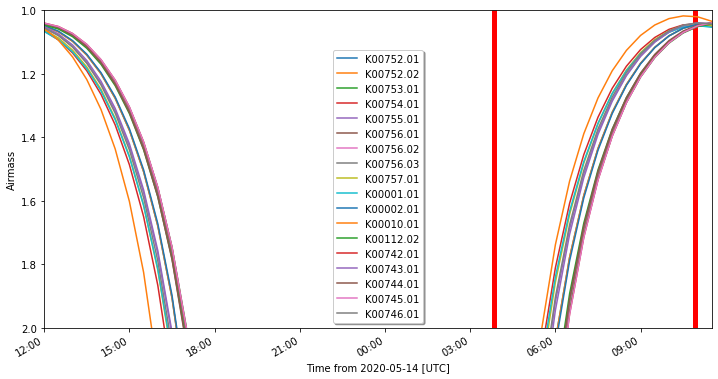

In [144]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(10,5)

fig.tight_layout()

for i, my_object in enumerate(target):
    if obsTable['ever observable'][i]:
        ax = plot_airmass(my_object, kittpeak, window_time_grid, max_airmass = 2)

ax.vlines(observe_start.datetime, 1,3, color='r', linewidth=5)
ax.vlines(observe_end.datetime, 1,3, color='r', linewidth=5)

ax.legend(loc=0,shadow=True);

In [21]:
observe_length = (observe_end - observe_start)
for i, my_object in enumerate(target):

    if obsTable['ever observable'][i]:
        name = obsTable['target name'][i]
        obj_frac = obsTable['fraction of time observable'][i]
        obj_time = obj_frac * observe_length
        ra = my_object.ra
        dec = my_object.dec
        output = "{0} {1:s} for {2:.2f} at  RA: {3} Dec: {4} " .format(i,name, obj_time.to(u.h), ra, dec)
        print(output)

0 K00752.01 for 6.44 h at  RA: 291.93422999999996 deg Dec: 48.141651 deg 
1 K00752.02 for 6.44 h at  RA: 291.93422999999996 deg Dec: 48.141651 deg 
2 K00753.01 for 5.94 h at  RA: 297.00482 deg Dec: 48.134128999999994 deg 
3 K00754.01 for 6.44 h at  RA: 285.53461 deg Dec: 48.28521 deg 
4 K00755.01 for 6.44 h at  RA: 288.75487999999996 deg Dec: 48.2262 deg 
5 K00756.01 for 5.94 h at  RA: 296.28612999999996 deg Dec: 48.22467 deg 
6 K00756.02 for 5.94 h at  RA: 296.28612999999996 deg Dec: 48.22467 deg 
7 K00756.03 for 5.94 h at  RA: 296.28612999999996 deg Dec: 48.22467 deg 
8 K00114.01 for 5.94 h at  RA: 298.86435 deg Dec: 42.151569 deg 
9 K00757.01 for 6.44 h at  RA: 286.99948 deg Dec: 48.37579 deg 
10 K00001.01 for 6.44 h at  RA: 286.80847 deg Dec: 49.316399 deg 
11 K00002.01 for 6.44 h at  RA: 292.24728 deg Dec: 47.969521 deg 
12 K00010.01 for 6.44 h at  RA: 281.28812 deg Dec: 42.45108 deg 
13 K00112.02 for 5.94 h at  RA: 295.64871 deg Dec: 48.49556 deg 
14 K00742.01 for 5.94 h at  RA: 

If the observign run is made to be one month later then then the same notbook can be run, but this time the observing window must be changed. 

In [5]:
window_start = Time("2020-06-14 12:00:00")
window_end = Time("2020-06-15 12:00:00")

In [9]:
observe_start = kittpeak.twilight_evening_astronomical(window_start, which = 'next')
observe_end  = kittpeak.twilight_morning_astronomical(window_end, which = 'nearest')
obs_length = observe_end - observe_start
print(observe_start.to_datetime(kittpeak.timezone))
print(observe_end.to_datetime(kittpeak.timezone))
print("The observing window on June 14th at Kitt Peak is {}".format(obs_length.to_datetime()))

2020-06-14 22:13:50.665970-06:00
2020-06-15 04:39:59.833399-06:00
The observing window on June 14th at Kitt Peak is 6:26:09.167429


The moon on this date will be in the third quarter. This is again helpful because it will not drastically overlap with the observation period. 

In [14]:
constraints = [MoonSeparationConstraint(70*u.deg)]

window_range = [window_start, window_end]
window_time_grid = time_grid_from_range(window_range)

observing_range = [observe_start, observe_end]
obsTable = observability_table(constraints, kittpeak, target, time_range = observing_range)
print(obsTable)

target name ever observable always observable fraction of time observable
----------- --------------- ----------------- ---------------------------
  K00752.01            True              True                         1.0
  K00752.02            True              True                         1.0
  K00753.01            True              True                         1.0
  K00754.01            True              True                         1.0
  K00755.01            True              True                         1.0
  K00756.01            True              True                         1.0
  K00756.02            True              True                         1.0
  K00756.03            True              True                         1.0
  K00114.01            True              True                         1.0
  K00757.01            True              True                         1.0
  K00001.01            True              True                         1.0
  K00002.01            True           

target name ever observable always observable fraction of time observable
----------- --------------- ----------------- ---------------------------
  K00752.01            True              True                         1.0
  K00752.02            True              True                         1.0
  K00753.01            True             False          0.9230769230769231
  K00754.01            True              True                         1.0
  K00755.01            True              True                         1.0
  K00756.01            True             False          0.9230769230769231
  K00756.02            True             False          0.9230769230769231
  K00756.03            True             False          0.9230769230769231
  K00114.01            True             False          0.9230769230769231
  K00757.01            True              True                         1.0
  K00001.01            True              True                         1.0
  K00002.01            True           

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


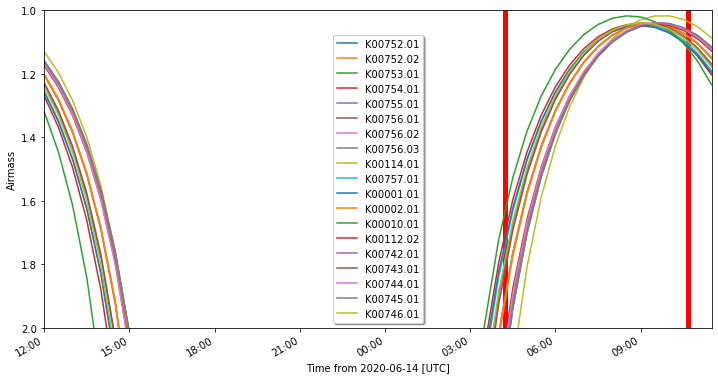

In [16]:
constraints.append(AirmassConstraint(2))
obsTable = observability_table(constraints, kittpeak, target, time_range = observing_range)
print(obsTable)

fig,ax = plt.subplots(1,1)
fig.set_size_inches(10,5)

fig.tight_layout()

for i, my_object in enumerate(target):
    if obsTable['ever observable'][i]:
        ax = plot_airmass(my_object, kittpeak, window_time_grid, max_airmass = 2)

ax.vlines(observe_start.datetime, 1,3, color='r', linewidth=5)
ax.vlines(observe_end.datetime, 1,3, color='r', linewidth=5)

ax.legend(loc=0,shadow=True);

**With the new observing date** the observation of the 20 KOI's is unaffected. In fact, because the moon is further into the third quarter, all 20 of the objects are now observable. 

In [19]:
observe_length = (observe_end - observe_start)
for i, my_object in enumerate(target):

    if obsTable['ever observable'][i]:
        name = obsTable['target name'][i]
        obj_frac = obsTable['fraction of time observable'][i]
        obj_time = obj_frac * observe_length
        ra = my_object.ra
        dec = my_object.dec
        output = "{0} {1:s} for {2:.2f} at  RA: {3} Dec: {4} " .format(i,name, obj_time.to(u.h), ra, dec)
        print(output)

0 K00752.01 for 6.44 h at  RA: 291.93422999999996 deg Dec: 48.141651 deg 
1 K00752.02 for 6.44 h at  RA: 291.93422999999996 deg Dec: 48.141651 deg 
2 K00753.01 for 5.94 h at  RA: 297.00482 deg Dec: 48.134128999999994 deg 
3 K00754.01 for 6.44 h at  RA: 285.53461 deg Dec: 48.28521 deg 
4 K00755.01 for 6.44 h at  RA: 288.75487999999996 deg Dec: 48.2262 deg 
5 K00756.01 for 5.94 h at  RA: 296.28612999999996 deg Dec: 48.22467 deg 
6 K00756.02 for 5.94 h at  RA: 296.28612999999996 deg Dec: 48.22467 deg 
7 K00756.03 for 5.94 h at  RA: 296.28612999999996 deg Dec: 48.22467 deg 
8 K00114.01 for 5.94 h at  RA: 298.86435 deg Dec: 42.151569 deg 
9 K00757.01 for 6.44 h at  RA: 286.99948 deg Dec: 48.37579 deg 
10 K00001.01 for 6.44 h at  RA: 286.80847 deg Dec: 49.316399 deg 
11 K00002.01 for 6.44 h at  RA: 292.24728 deg Dec: 47.969521 deg 
12 K00010.01 for 6.44 h at  RA: 281.28812 deg Dec: 42.45108 deg 
13 K00112.02 for 5.94 h at  RA: 295.64871 deg Dec: 48.49556 deg 
14 K00742.01 for 5.94 h at  RA: 